# **Using YOLOv10 for credit card process**

This notebook shows the process to used the fine-tuned **YOLOv10** in this project for the following tasks:
* Credit/Debit card detection.
* Credit/Debit elements card detection.
* Payment Network classification

<!-- ![Texto alternativo](./assets/schema.png) -->
<img src="./assets/schema.png" alt="Texto alternativo" style="border-radius: 15px; width: 1400px;"/>


## **Import Libraries**

In [54]:
from ultralytics import YOLO
from dotenv import load_dotenv
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torchvision as tv

#### Load the environment variables in the notebook context

In [55]:
load_dotenv("../../.env")

True

## **Task 1:** 

* Load `YOLOv10n_CardDetector` model
* Detect the credit card on image with a fine-tunned YOLO model.
* Cut the credit card from image with results of our model.

In [56]:
# Load card detector model
CARD_DETECTOR_DIR = os.getenv("YOLO_CARD_DETECTOR")
card_detector = YOLO(CARD_DETECTOR_DIR)
card_detector

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

Load the initial image to work in this notebook

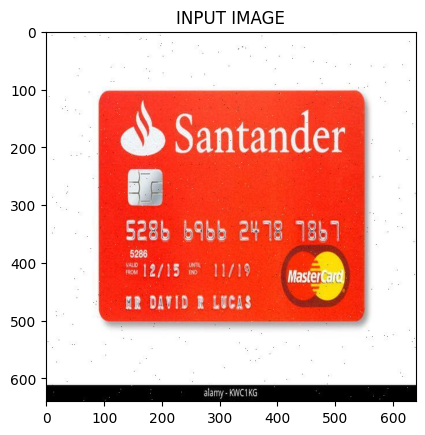

In [57]:
IMG_PATH = "../../data/example.jpg"
input_image = cv2.imread(filename=IMG_PATH)
img_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

# Show the image with matplotlib
plt.imshow(img_rgb)
plt.title("INPUT IMAGE")
plt.show()

Perform image inference to detect the card in the image.


0: 640x640 1 credit_card, 133.0ms
Speed: 2.7ms preprocess, 133.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


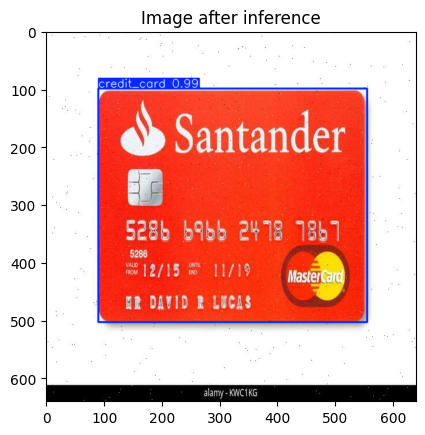

Results
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'credit_card'}
obb: None
orig_img: array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],

In [58]:
result = card_detector(source=input_image)

# Show the result
plt.imshow(cv2.cvtColor(result[0].plot(), cv2.COLOR_BGR2RGB))
plt.title("Image after inference")
plt.show()

print(f"Results\n{result}")

Great! Now that our model has detected the card, we need to cut it out to remove the background that we are not interested in, and then in the second step we can detect the elements of the card. 

In [59]:
def crop_image(img: np.ndarray, coords: list):
    """
    Crops the given image to the specified coordinates.

    Parameters:
    img (np.ndarray): The input image as a NumPy array.
    coords (list): A list of coordinates [x1, y1, x2, y2] defining the top-left (x1, y1)
                   and bottom-right (x2, y2) corners of the cropping rectangle. 
                   Coordinates are cast to int, and clipped to be within the image boundaries.

    Returns:
    np.ndarray: The cropped region of the image as a NumPy array.
    """
    # Cast coords to int 
    x1, y1, x2, y2 = map(int, coords)
    # Make sure the coordinates are 
    # within the image boundaries.
    height, width = img.shape[:2]
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(width, x2), min(height, y2)
    
    crop_image = img[y1:y2, x1:x2]
    return crop_image

### Crop the credit card

Bounding box of credit/debit card -> [[90.66522216796875, 99.46502685546875, 555.1876220703125, 503.972412109375]]
Confidences of credit/debit card -> [0.0]


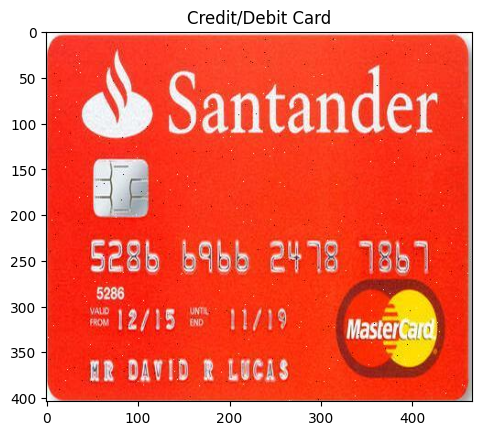

In [60]:
# Extract bounding box coordinates from the result and move the tensor to the CPU
xyxy = result[0].boxes.xyxy.cpu()
# Extract class labels from the result and move the tensor to the CPU
clss = result[0].boxes.cls.cpu()
# Perform non-maximum suppression (NMS) to filter out overlapping and redundant bounding boxes
# The resulting 'filtered_id_boxes' contains the indices of the bounding boxes to keep
filtered_id_boxes = tv.ops.nms(xyxy, clss, iou_threshold=0.5)

# Select and convert the filtered bounding boxes to a list
xyxy = xyxy[filtered_id_boxes].tolist()
# Select and convert the filtered class labels to a list
clss = clss[filtered_id_boxes].tolist()

if len(xyxy) == 1:
    # Show results
    print(f"Bounding box of credit/debit card -> {xyxy}")
    print(f"Confidences of credit/debit card -> {clss}")
    credit_card = crop_image(img=input_image,
                             coords=xyxy[0])
    credit_card = cv2.cvtColor(credit_card, cv2.COLOR_BGR2RGB)
    plt.imshow(credit_card)
    plt.title("Credit/Debit Card")
    plt.show()
else:
    print("Error -> Image not valid")
    credit_card = None

Well, with this we are finishing the **Task 1**. So during this task, we have detected and cut out a credit card from an image.

## Task 2:

* Load the `YOLOv10n_ElementsCardDetector` model
* Detect the different elements from credit/debit card
* Cut the different elements and show them
* Shows the card elements with `matplotlib`

**NOTE:**

0: Cardnumber

1: Expiry Date

2: Cardholder

3: Payment Network

In [61]:
# Load elements detector model
CARD_ELEMENTS_DETECTOR_DIR = os.getenv("YOLO_CARD_ELEMENT_DETECTOR")
elements_detector = YOLO(CARD_ELEMENTS_DETECTOR_DIR)
elements_detector

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

If, we could be detected the credit card in the **Task 1**, now swipe the card through the item detector


0: 576x640 1 card_number, 1 expiry_date, 1 cardholder, 1 payment_network, 86.6ms
Speed: 3.9ms preprocess, 86.6ms inference, 0.2ms postprocess per image at shape (1, 3, 576, 640)
Boxes
[[320.50140380859375, 273.3130798339844, 436.4563903808594, 370.7305603027344], [46.8582649230957, 354.9588623046875, 266.791015625, 386.27288818359375], [198.801513671875, 300.5521545410156, 264.2178955078125, 330.1937561035156], [47.71942138671875, 225.4867401123047, 419.2708740234375, 266.8592834472656]]
Confidences
[3.0, 2.0, 1.0, 0.0]


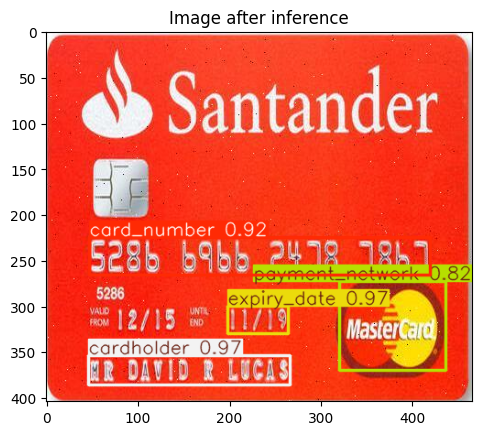

In [62]:
if credit_card is not None:
    result = elements_detector(source=credit_card)
    xyxy = result[0].boxes.xyxy.cpu()
    clss = result[0].boxes.cls.cpu()
    filtered_id_boxes = tv.ops.nms(xyxy, clss, iou_threshold=0.5)
    
    # Select and convert the filtered bounding boxes to a list
    xyxy = xyxy[filtered_id_boxes].tolist()
    # Select and convert the filtered class labels to a list
    clss = clss[filtered_id_boxes].tolist()
    
    print(f"Boxes\n{xyxy}")
    print(f"Confidences\n{clss}")
    plt.imshow(result[0].plot())
    plt.title("Image after inference")
    plt.show()

Now cut out card elements from credit card image

In [63]:
# Cut the card elements from credit card image
card_number = None
expiry_date = None
cardholder = None
payment_network = None
for box, cls in zip(xyxy, clss):
    print(f"Box {box} - cls {cls}")
    if cls == 0.0:
        card_number = crop_image(img=credit_card,
                                 coords=box)
    elif cls == 1.0:
        expiry_date = crop_image(img=credit_card,
                                 coords=box)
    elif cls == 2.0:
        cardholder = crop_image(img=credit_card,
                                coords=box)
    elif cls == 3.0:
        payment_network = crop_image(img=credit_card,
                                     coords=box)
    else:
        pass


# Check the cuts
card_number = card_number if card_number is not None else None
cardholder = cardholder if cardholder is not None else None
expiry_date = expiry_date if expiry_date is not None else None
payment_network = payment_network if payment_network is not None else None 

Box [320.50140380859375, 273.3130798339844, 436.4563903808594, 370.7305603027344] - cls 3.0
Box [46.8582649230957, 354.9588623046875, 266.791015625, 386.27288818359375] - cls 2.0
Box [198.801513671875, 300.5521545410156, 264.2178955078125, 330.1937561035156] - cls 1.0
Box [47.71942138671875, 225.4867401123047, 419.2708740234375, 266.8592834472656] - cls 0.0


### Show the results

In [64]:
def show(images: list, labels: list):
    # Create subplots
    fig, ax = plt.subplots(1, len(images), figsize=(10, 5))

    index = 0
    for image, label in zip(images, labels):
        if image is None:
            image = np.zeros((32, 32, 3), dtype=np.uint8)
            
        ax[index].imshow(image)
        ax[index].set_title(label)
        ax[index].axis('off')
        fig.tight_layout()
        index += 1
    
    plt.show()        

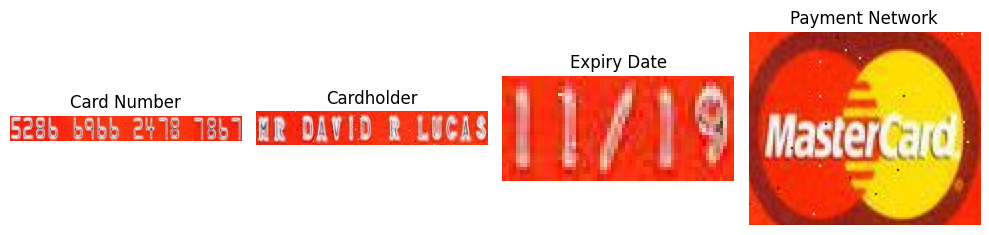

In [65]:
images = [card_number, cardholder, expiry_date, payment_network]
labels = ["Card Number", "Cardholder", "Expiry Date", "Payment Network"]
show(images=images, labels=labels)

Well with this we have finished the second task of this notebook.

## **Task 3**

* Load the `YOLOv10n_PaymentNetworkClassifierd` model
* Classify the payment network extracted in the previous task

In [66]:
# Load classifier model
PAYMENT_NETWORK_CLASSIFIER = os.getenv("PAYMENT_NETWORK_CLASSIFIER_DIR")
classifier = YOLO(PAYMENT_NETWORK_CLASSIFIER)
classifier

YOLO(
  (model): ClassificationModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_

* Now, check if the payment network was detected in the previous task


0: 128x128 Mastercard 1.00, VISA 0.00, AmericanExpress 0.00, Cabal 0.00, 4.7ms
Speed: 6.4ms preprocess, 4.7ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)


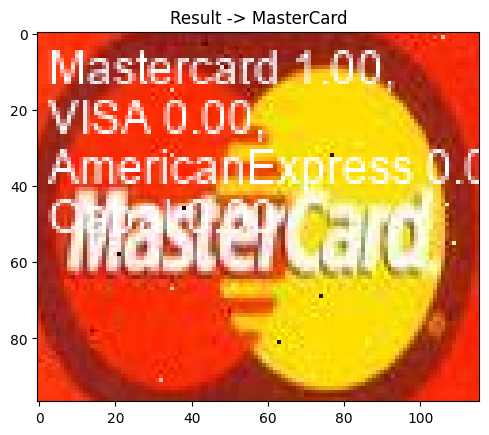

In [67]:
if payment_network is None:
    exit()
    
result = classifier(source=payment_network)

top1 = result[0].probs.top1
top1_conf = result[0].probs.top1conf

if top1 == 0:
    payment_network_str = "American Express"
elif top1 == 1:
    payment_network_str = "Cabal"
elif top1 == 2:
    payment_network_str = "MasterCard"
elif top1 == 3:
    payment_network_str = "VISA"
else:
    pass

plt.imshow(result[0].plot())
plt.title(f"Result -> {payment_network_str}")
plt.show()

## **End**

With this, the process ends, represented in a Jupyter Notebook with visual purposes of explaining step by step first how to detect a credit card on a image with `YOLOv10n_CardDetector` fine-tunned model, then how to detect the elements of a card with `YOLOv10n_ElementsCardDetector`. Finally, shows how to classify the payment network obtained on task 2 with `YOLOv10n_PaymentNetworkClassifier`.

This three models are the fine-tunned YOLO models in this research project.